### <font color='orangered'>Importing Libraries

In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import pickle

In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import NearMiss


### <font color='orangered'>Reading the Input Data

In [27]:
drought_df = pd.read_csv('train_timeseries.csv')
drought_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


### <font color='orangered'>Initial Exploration and Data Cleaning (Data Wrangling)


In [29]:
drought_df.info()
# import numpy as np
# print(np.__version__)
# !pip3 install numpy --upgrade

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


In [30]:
drought_df.isnull().sum()


fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          16543884
dtype: int64

#### <font color='darkblue'>Missing Value Treatment

In [32]:
# Removing the null values in the target variable, as the drought score is only available once every 7 days.
drought_df = drought_df.dropna()
drought_df.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

#### <font color='darkblue'>Reformatting the data

In [34]:
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score          float64
dtype: object

In [35]:
drought_df['year'] = pd.DatetimeIndex(drought_df['date']).year
drought_df['month'] = pd.DatetimeIndex(drought_df['date']).month
drought_df['day'] = pd.DatetimeIndex(drought_df['date']).day
drought_df['score'] = drought_df['score'].round().astype(int)
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int64
year             int32
month            int32
day              int32
dtype: object

In [36]:
drought_df['fips'].nunique()

3108

In [37]:
drought_df['score'].round().value_counts()

score
0    1652230
1     466944
2     295331
3     196802
4     106265
5      39224
Name: count, dtype: int64

### <font color='orangered'>**Exploratory Data Analysis**

#### <font color='darkblue'>Univariate Analysis - Descriptive Statistics

In [40]:
column_list = list(drought_df.columns)
column_list

['fips',
 'date',
 'PRECTOT',
 'PS',
 'QV2M',
 'T2M',
 'T2MDEW',
 'T2MWET',
 'T2M_MAX',
 'T2M_MIN',
 'T2M_RANGE',
 'TS',
 'WS10M',
 'WS10M_MAX',
 'WS10M_MIN',
 'WS10M_RANGE',
 'WS50M',
 'WS50M_MAX',
 'WS50M_MIN',
 'WS50M_RANGE',
 'score',
 'year',
 'month',
 'day']

#### <font color='darkblue'>Univariate Analysis - Distribution of Continuous Variables

In [42]:
measures_column_list = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
drought_df_measures = drought_df[['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']]

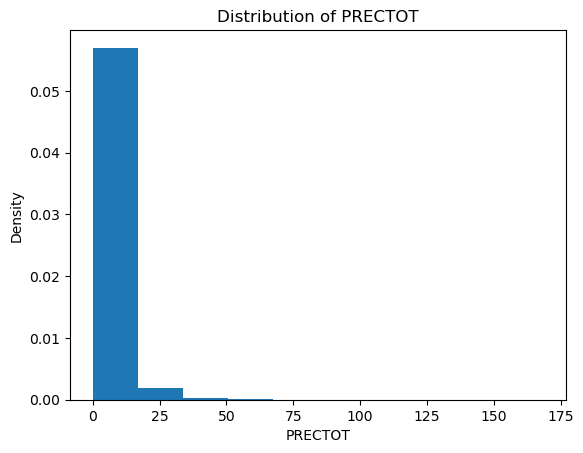

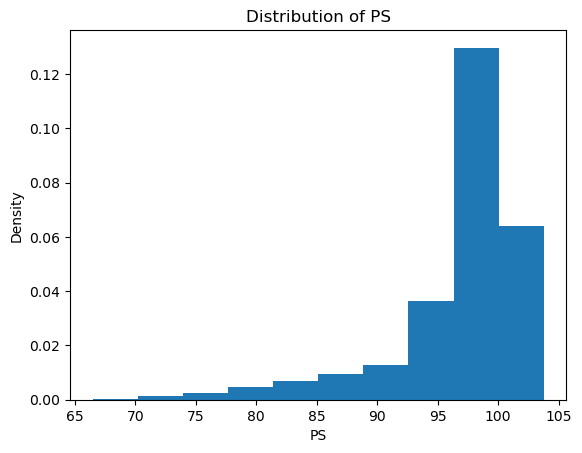

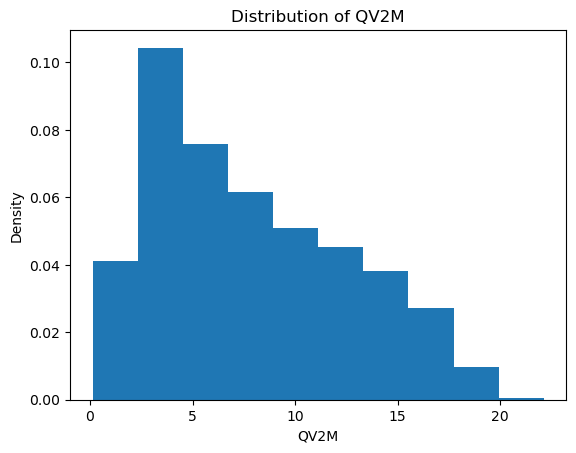

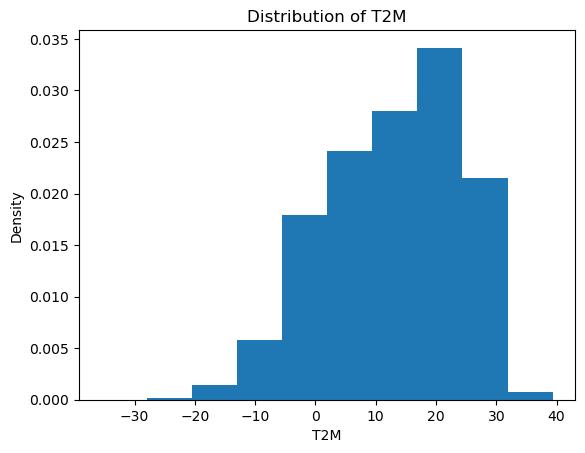

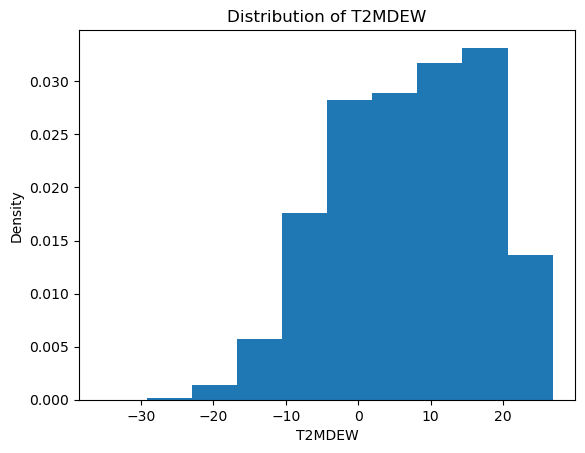

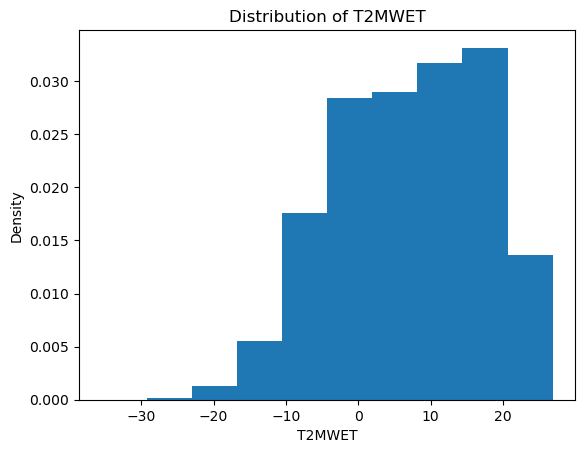

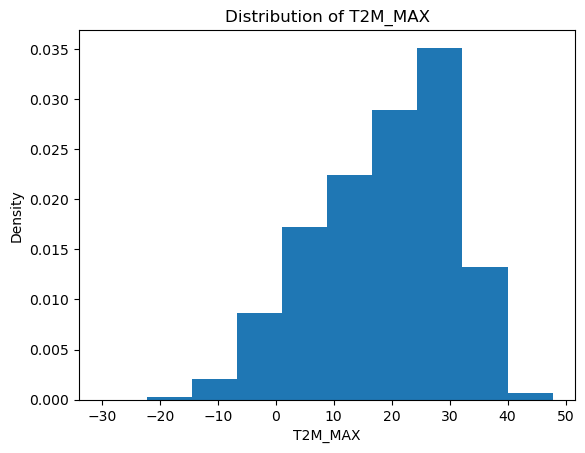

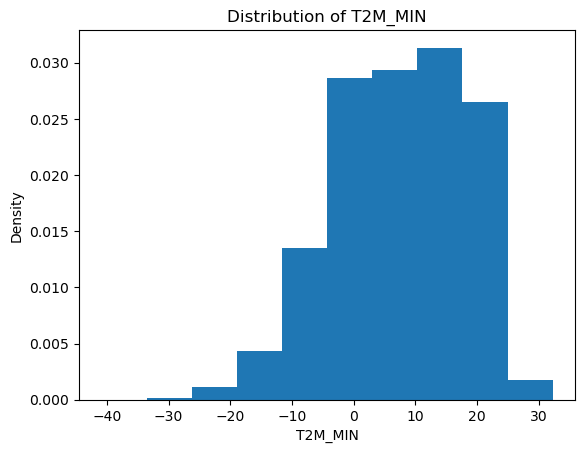

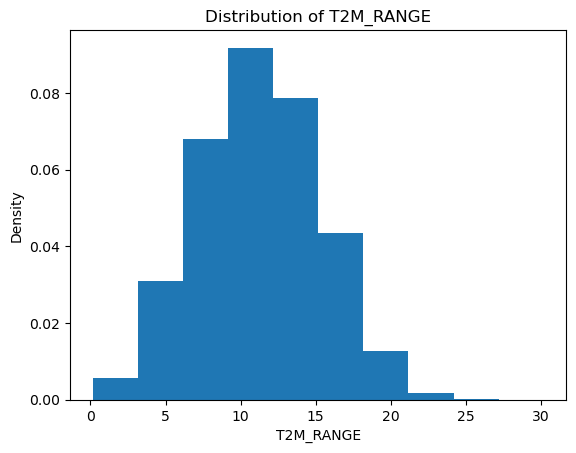

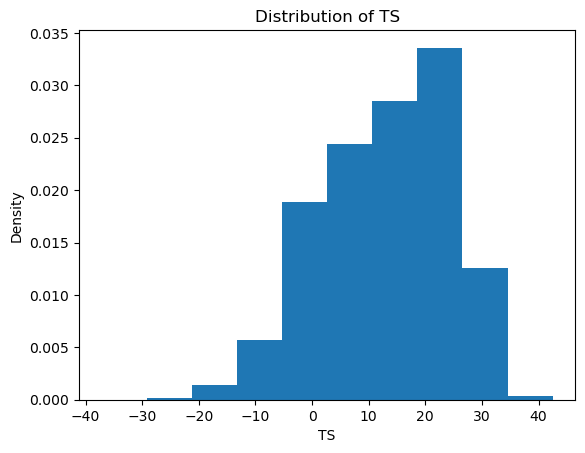

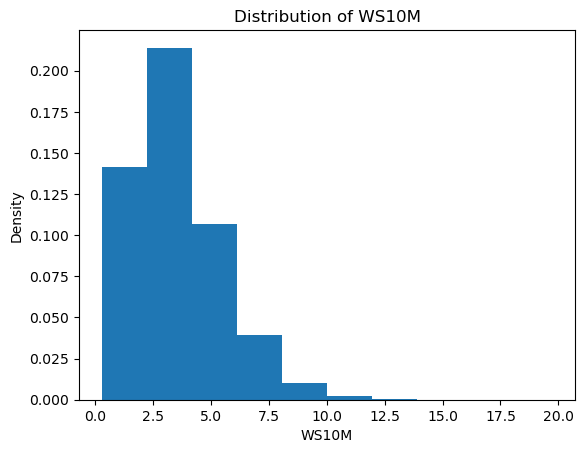

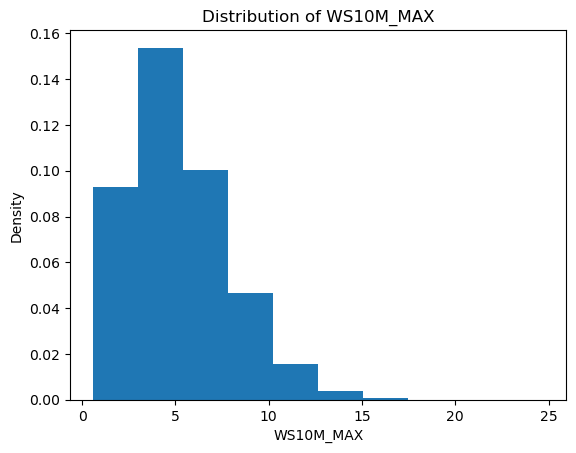

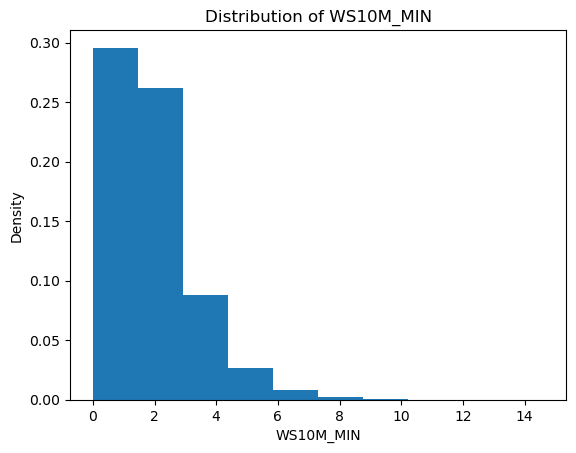

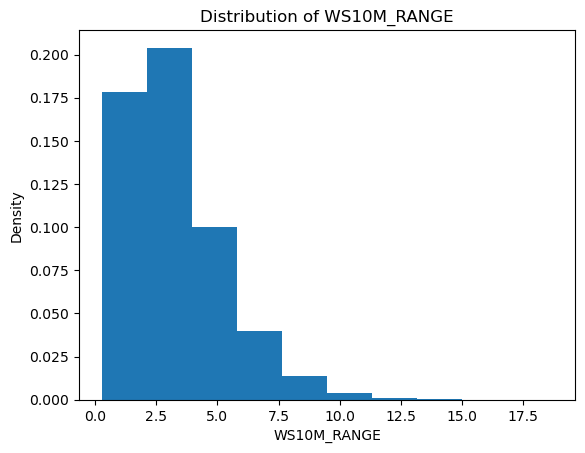

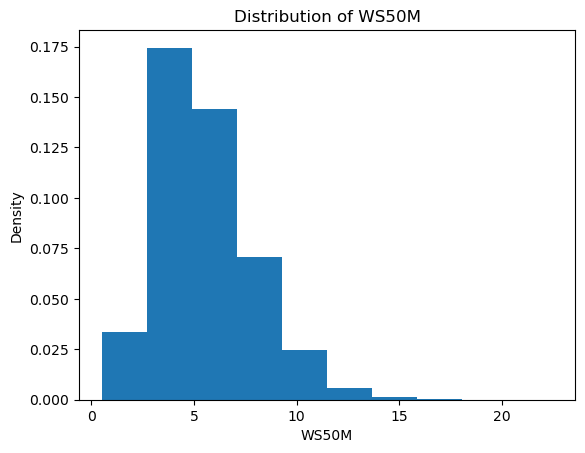

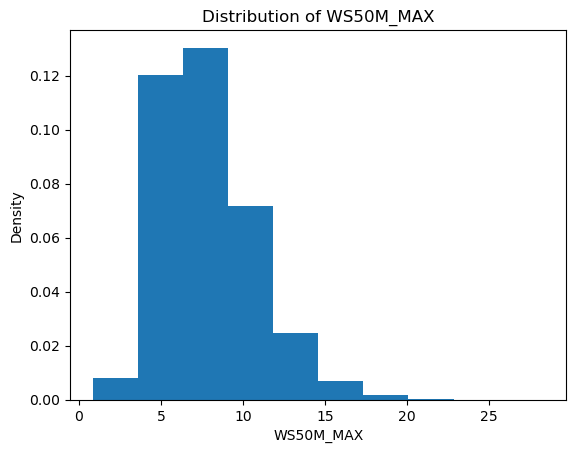

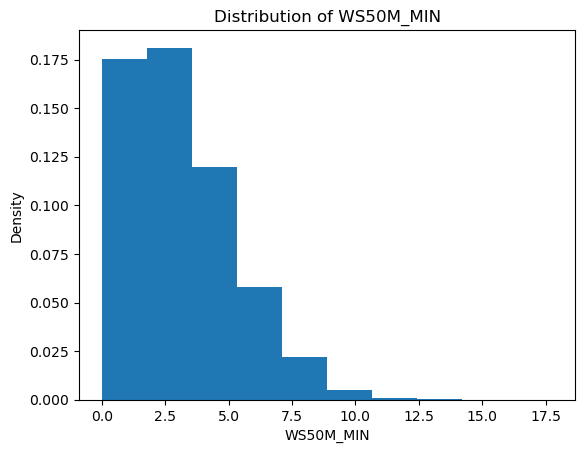

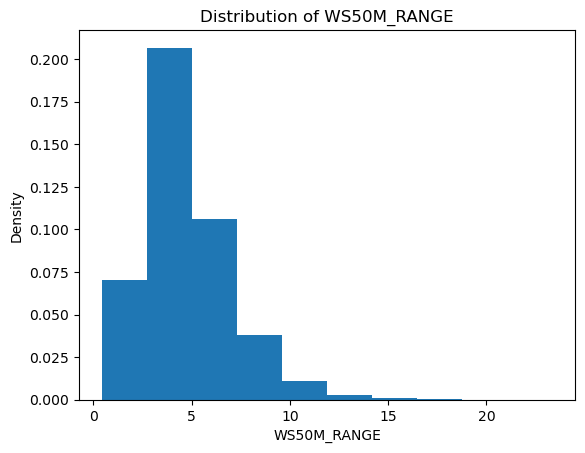

In [43]:
for col_name in measures_column_list:
    plt.figure()
    plt.hist(drought_df_measures[col_name], density = True)
    x_name = col_name
    plt.xlabel(x_name)
    y_name = 'Density'
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))

### <font color='darkblue'>Outlier Treatment

#### <font color='blue'>Identifying Outliers

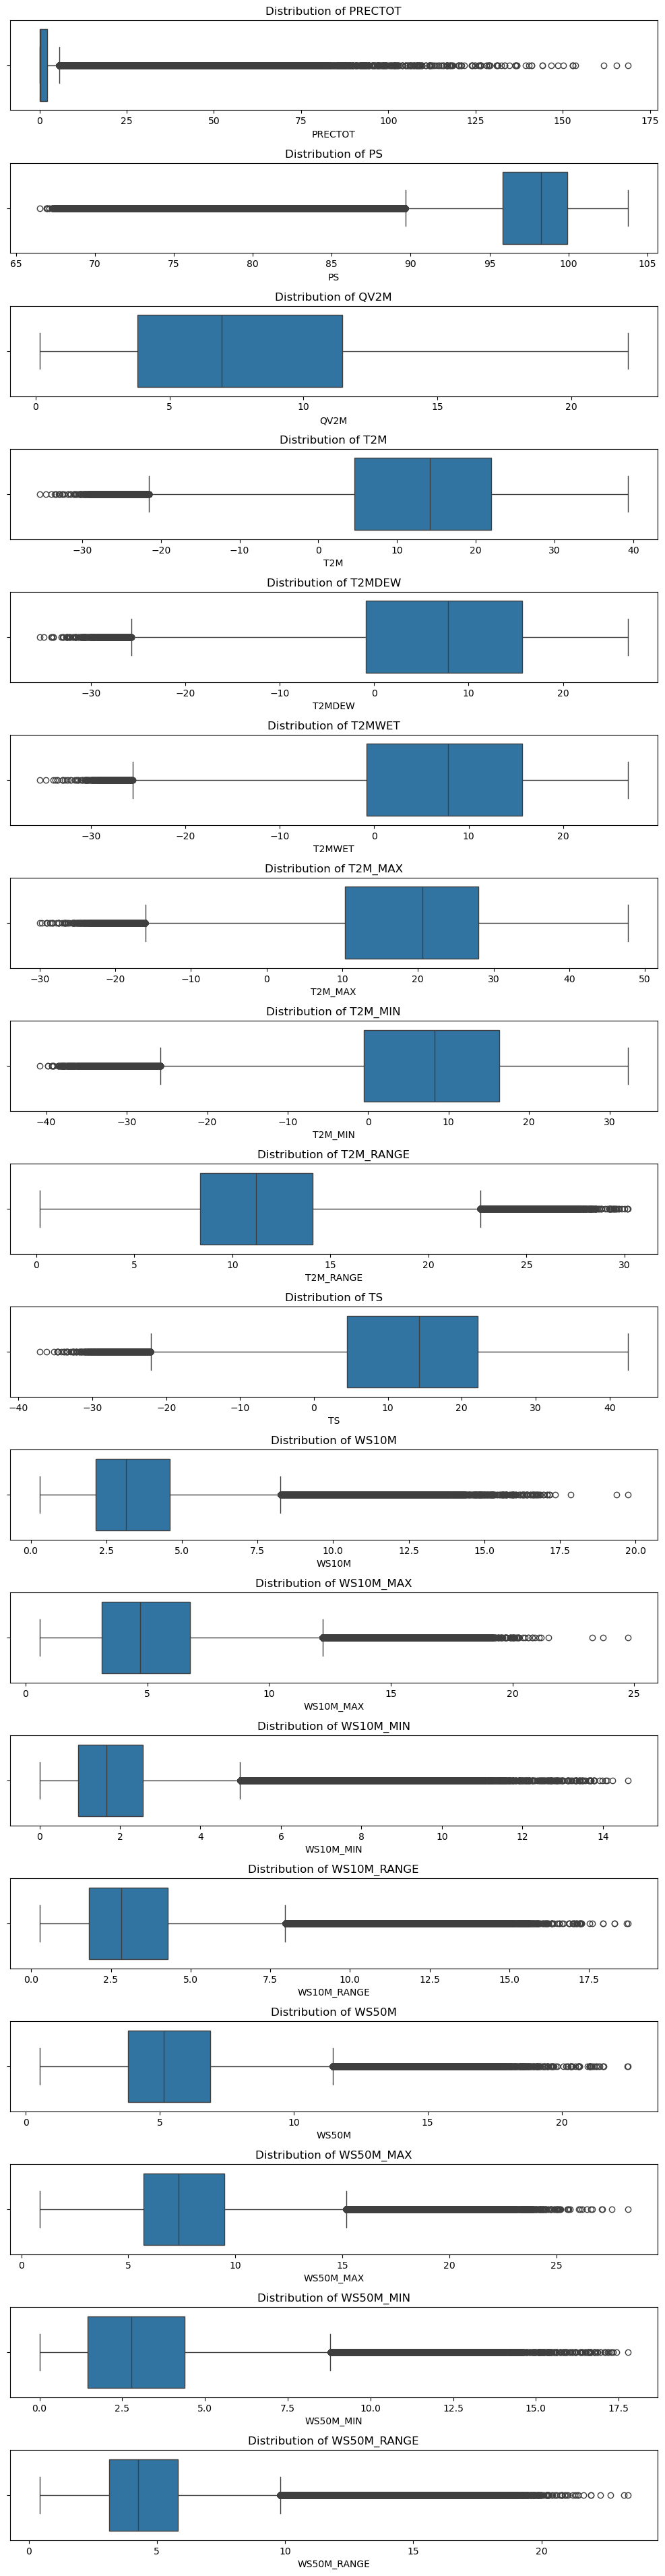

In [46]:
plt.figure(figsize=(10,40))
for x in (range(1,19)):
    plt.subplot(19,1,x)
    sns.boxplot(x =  drought_df_measures.columns[x-1], data=drought_df_measures)
    x_name = drought_df_measures.columns[x-1]
    plt.title(f'Distribution of {x_name}')
plt.tight_layout()

In [47]:
print('Total rows = ',len(drought_df_measures.index))
for i in drought_df_measures.select_dtypes(exclude = ['object']).columns:
    print ('Number of values beyond standard outlier limit in ', i)
    print(len(drought_df_measures[(drought_df_measures[i] > drought_df_measures[i].mean() + 3*drought_df_measures[i].std()) | (drought_df_measures[i] < drought_df_measures[i].mean() - 3*drought_df_measures[i].std())]))

Total rows =  2756796
Number of values beyond standard outlier limit in  PRECTOT
65933
Number of values beyond standard outlier limit in  PS
73197
Number of values beyond standard outlier limit in  QV2M
1
Number of values beyond standard outlier limit in  T2M
4531
Number of values beyond standard outlier limit in  T2MDEW
2023
Number of values beyond standard outlier limit in  T2MWET
1814
Number of values beyond standard outlier limit in  T2M_MAX
3384
Number of values beyond standard outlier limit in  T2M_MIN
6944
Number of values beyond standard outlier limit in  T2M_RANGE
3628
Number of values beyond standard outlier limit in  TS
4762
Number of values beyond standard outlier limit in  WS10M
29954
Number of values beyond standard outlier limit in  WS10M_MAX
23387
Number of values beyond standard outlier limit in  WS10M_MIN
39901
Number of values beyond standard outlier limit in  WS10M_RANGE
35979
Number of values beyond standard outlier limit in  WS50M
23090
Number of values beyond sta

#### <font color='black'>Removing Values Beyond the Standard Outlier Limit

In [49]:
drought_df = drought_df[(drought_df['PRECTOT'] <= drought_df['PRECTOT'].mean() + 3*drought_df['PRECTOT'].std()) &
        (drought_df['PRECTOT'] >= drought_df['PRECTOT'].mean() - 3*drought_df['PRECTOT'].std())]

drought_df = drought_df[(drought_df['PS'] <= drought_df['PS'].mean() + 3*drought_df['PS'].std()) &
        (drought_df['PS'] >= drought_df['PS'].mean() - 3*drought_df['PS'].std())]

drought_df = drought_df[(drought_df['QV2M'] <= drought_df['QV2M'].mean() + 3*drought_df['QV2M'].std()) &
        (drought_df['QV2M'] >= drought_df['QV2M'].mean() - 3*drought_df['QV2M'].std())]

drought_df = drought_df[(drought_df['T2M'] <= drought_df['T2M'].mean() + 3*drought_df['T2M'].std()) &
        (drought_df['T2M'] >= drought_df['T2M'].mean() - 3*drought_df['T2M'].std())]

drought_df = drought_df[(drought_df['T2MDEW'] <= drought_df['T2MDEW'].mean() + 3*drought_df['T2MDEW'].std()) &
        (drought_df['T2MDEW'] >= drought_df['T2MDEW'].mean() - 3*drought_df['T2MDEW'].std())]

drought_df = drought_df[(drought_df['T2MWET'] <= drought_df['T2MWET'].mean() + 3*drought_df['T2MWET'].std()) &
        (drought_df['T2MWET'] >= drought_df['T2MWET'].mean() - 3*drought_df['T2MWET'].std())]

drought_df = drought_df[(drought_df['T2M_MAX'] <= drought_df['T2M_MAX'].mean() + 3*drought_df['T2M_MAX'].std()) &
        (drought_df['T2M_MAX'] >= drought_df['T2M_MAX'].mean() - 3*drought_df['T2M_MAX'].std())]

drought_df = drought_df[(drought_df['T2M_MIN'] <= drought_df['T2M_MIN'].mean() + 3*drought_df['T2M_MIN'].std()) &
        (drought_df['T2M_MIN'] >= drought_df['T2M_MIN'].mean() - 3*drought_df['T2M_MIN'].std())]

drought_df = drought_df[(drought_df['T2M_RANGE'] <= drought_df['T2M_RANGE'].mean() + 3*drought_df['T2M_RANGE'].std()) &
        (drought_df['T2M_RANGE'] >= drought_df['T2M_RANGE'].mean() - 3*drought_df['T2M_RANGE'].std())]

drought_df = drought_df[(drought_df['TS'] <= drought_df['TS'].mean() + 3*drought_df['TS'].std()) &
        (drought_df['TS'] >= drought_df['TS'].mean() - 3*drought_df['TS'].std())]

drought_df = drought_df[(drought_df['WS10M'] <= drought_df['WS10M'].mean() + 3*drought_df['WS10M'].std()) &
        (drought_df['WS10M'] >= drought_df['WS10M'].mean() - 3*drought_df['WS10M'].std())]

drought_df = drought_df[(drought_df['WS10M_MAX'] <= drought_df['WS10M_MAX'].mean() + 3*drought_df['WS10M_MAX'].std()) &
        (drought_df['WS10M_MAX'] >= drought_df['WS10M_MAX'].mean() - 3*drought_df['WS10M_MAX'].std())]

drought_df = drought_df[(drought_df['WS10M_MIN'] <= drought_df['WS10M_MIN'].mean() + 3*drought_df['WS10M_MIN'].std()) &
        (drought_df['WS10M_MIN'] >= drought_df['WS10M_MIN'].mean() - 3*drought_df['WS10M_MIN'].std())]

drought_df = drought_df[(drought_df['WS10M_RANGE'] <= drought_df['WS10M_RANGE'].mean() + 3*drought_df['WS10M_RANGE'].std()) &
        (drought_df['WS10M_RANGE'] >= drought_df['WS10M_RANGE'].mean() - 3*drought_df['WS10M_RANGE'].std())]

drought_df = drought_df[(drought_df['WS50M'] <= drought_df['WS50M'].mean() + 3*drought_df['WS50M'].std()) &
        (drought_df['WS50M'] >= drought_df['WS50M'].mean() - 3*drought_df['WS50M'].std())]

drought_df = drought_df[(drought_df['WS50M_MAX'] <= drought_df['WS50M_MAX'].mean() + 3*drought_df['WS50M_MAX'].std()) &
        (drought_df['WS50M_MAX'] >= drought_df['WS50M_MAX'].mean() - 3*drought_df['WS50M_MAX'].std())]

drought_df = drought_df[(drought_df['WS50M_MIN'] <= drought_df['WS50M_MIN'].mean() + 3*drought_df['WS50M_MIN'].std()) &
        (drought_df['WS50M_MIN'] >= drought_df['WS50M_MIN'].mean() - 3*drought_df['WS50M_MIN'].std())]

drought_df = drought_df[(drought_df['WS50M_RANGE'] <= drought_df['WS50M_RANGE'].mean() + 3*drought_df['WS50M_RANGE'].std()) &
        (drought_df['WS50M_RANGE'] >= drought_df['WS50M_RANGE'].mean() - 3*drought_df['WS50M_RANGE'].std())]

print('Total rows = ',len(drought_df.index))

Total rows =  2474338


#### <font color='darkblue'>Univariate Analysis - Distribution of Categorical Variables

In [51]:
categorical_column_list = ['score','year','month','day']
drought_df_categorical = drought_df[['score','year','month','day']]

<Figure size 1000x4000 with 0 Axes>

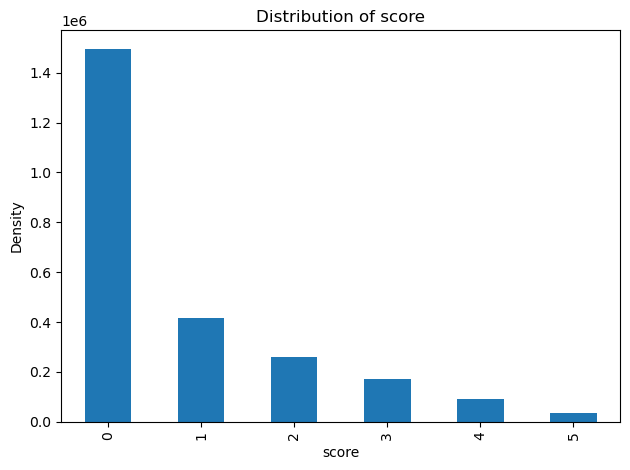

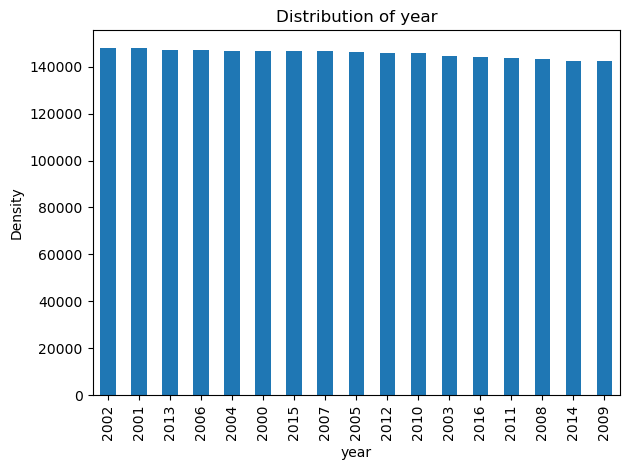

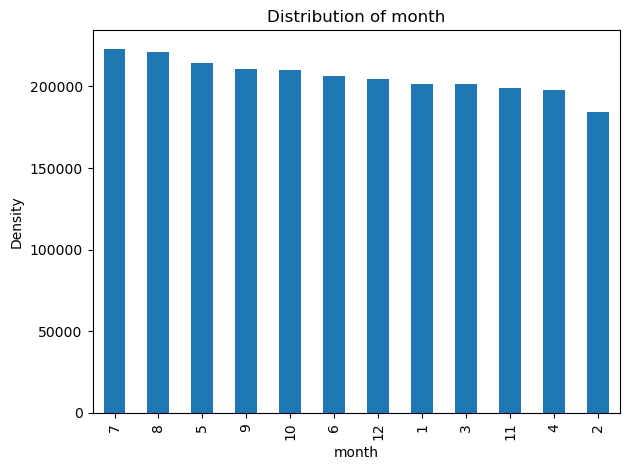

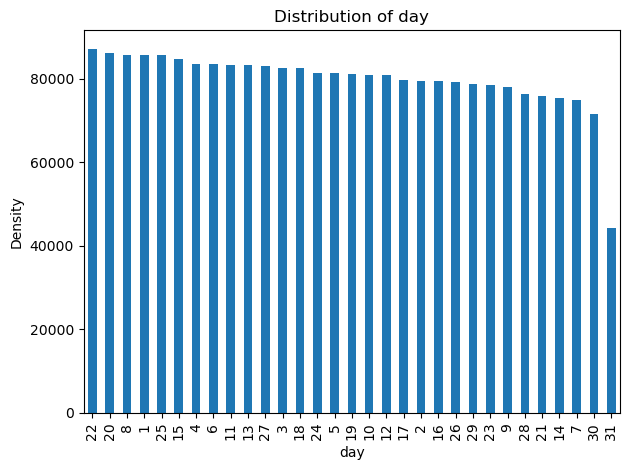

In [52]:
# Distribution of categorical variables
plt.figure(figsize=(10,40))
for col_name in categorical_column_list:
    plt.figure()
    drought_df_categorical[col_name].value_counts().plot(kind = 'bar')
    x_name = col_name
    y_name = 'Density'
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))
    plt.tight_layout()

#### <font color='darkblue'>Bivariate Analysis

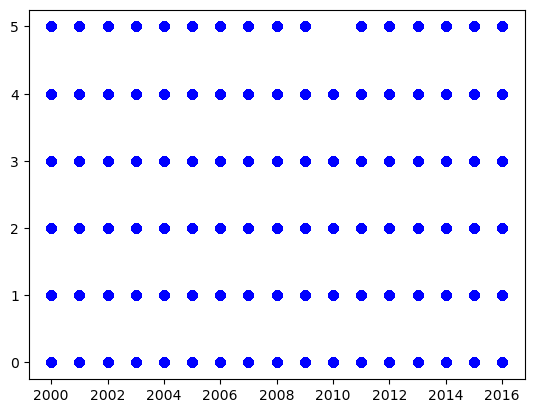

In [54]:
plt.scatter(drought_df['year'], drought_df['score'], c ="blue")
plt.show()

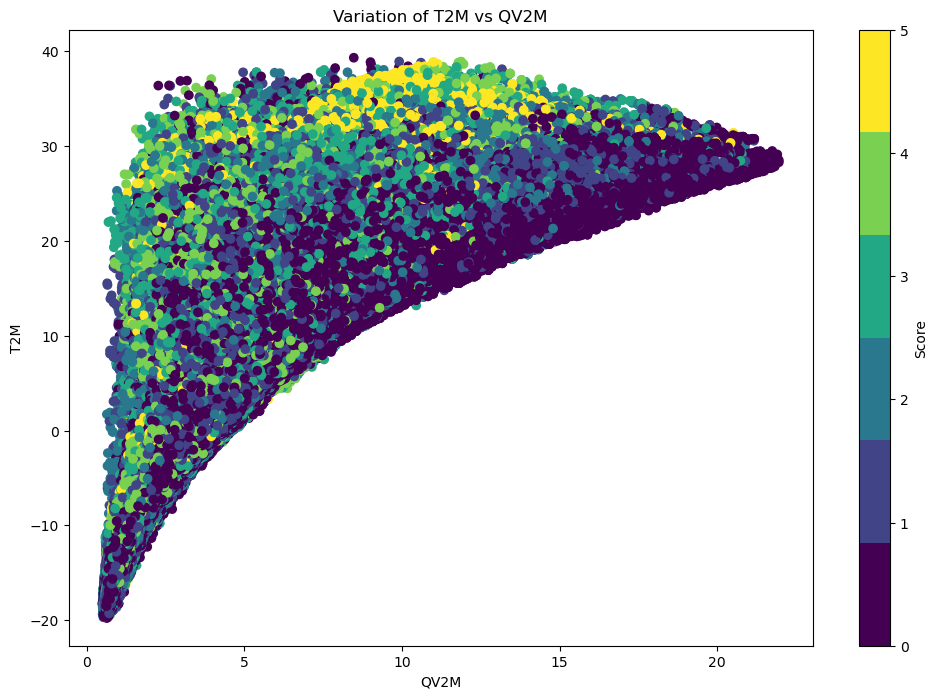

In [55]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.figure(figsize=(12,8))
# Define unique score categories
unique_scores = drought_df['score'].unique()

# Create a colormap
cmap = plt.cm.get_cmap('viridis', len(unique_scores))
scatter=plt.scatter(drought_df['QV2M'], drought_df['T2M'], c =drought_df['score'], cmap=cmap)
plt.xlabel('QV2M')
plt.ylabel('T2M')
plt.title('Variation of T2M vs QV2M')
# Create a colorbar for the score legend
cbar = plt.colorbar(scatter)
cbar.set_label('Score')
plt.show()

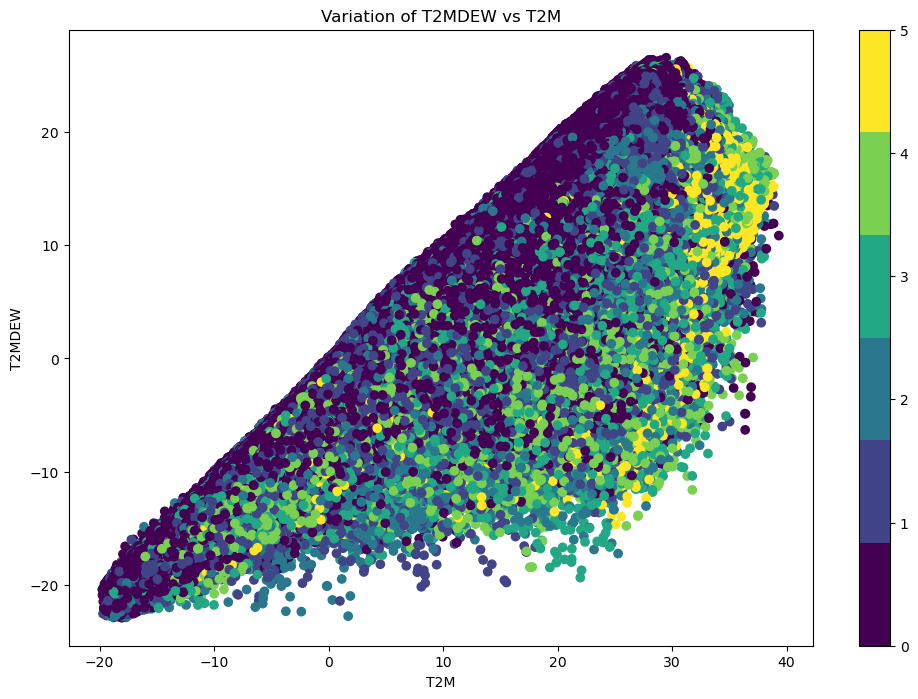

In [56]:
# Define unique score categories
unique_scores = drought_df['score'].unique()
plt.figure(figsize=(12,8))
# Create a colormap
cmap = plt.cm.get_cmap('viridis', len(unique_scores))
scatter=plt.scatter(drought_df['T2M'], drought_df['T2MDEW'], c =drought_df['score'], cmap=cmap)
plt.xlabel('T2M')
plt.ylabel('T2MDEW')
plt.title('Variation of T2MDEW vs T2M')
# Create a colorbar for the score legend
cbar = plt.colorbar(scatter)
plt.show()

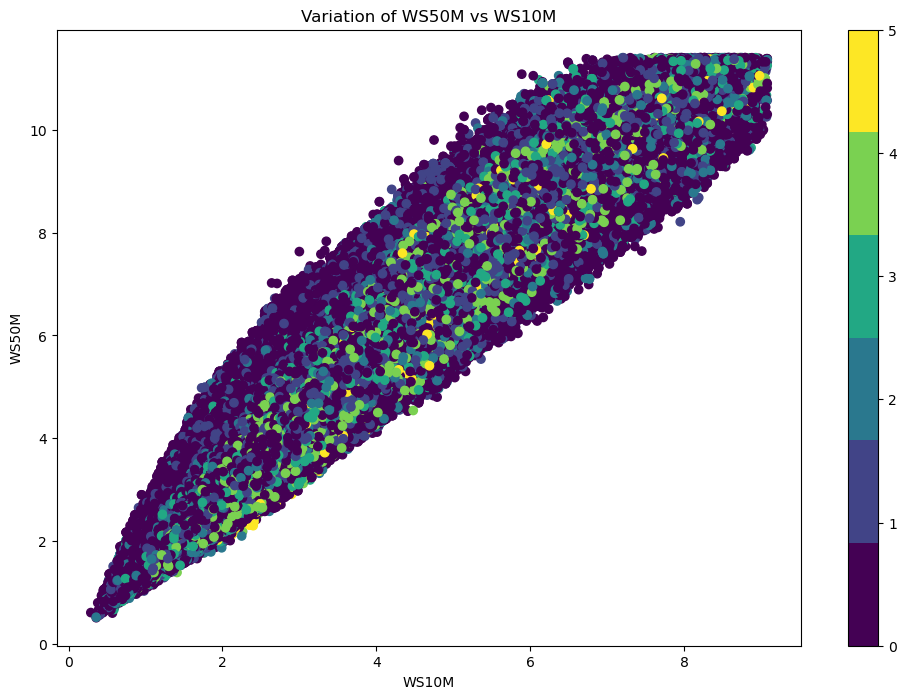

In [57]:
# Define unique score categories
unique_scores = drought_df['score'].unique()
plt.figure(figsize=(12,8))

# Create a colormap
cmap = plt.cm.get_cmap('viridis', len(unique_scores))
scatter=plt.scatter(drought_df['WS10M'], drought_df['WS50M'], c= drought_df['score'], cmap=cmap)
plt.xlabel('WS10M')
plt.ylabel('WS50M')
plt.title('Variation of WS50M vs WS10M')
# Create a colorbar for the score legend
cbar = plt.colorbar(scatter)
plt.show()

#### <font color='darkblue'> Extracting Dependent and Independent Variables

In [59]:
independent_variables = drought_df.drop('score',axis=1)
independent_variables = independent_variables.drop('fips', axis=1)
independent_variables = independent_variables.drop('date', axis=1)
independent_variables.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,year,month,day
3,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,...,5.67,2.08,3.59,6.73,9.31,3.74,5.58,2000,1,4
10,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,13.16,10.43,...,2.48,1.05,1.43,3.55,6.38,1.71,4.67,2000,1,11
17,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,9.06,14.19,...,3.60,1.67,1.92,5.19,6.40,3.84,2.55,2000,1,18
24,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,11.11,-0.61,...,4.59,2.28,2.32,5.75,8.03,3.96,4.07,2000,1,25
31,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,1.88,...,2.74,0.88,1.86,4.18,6.38,1.27,5.11,2000,2,1


In [60]:
target = drought_df['score']
target.head()

3     1
10    2
17    2
24    2
31    1
Name: score, dtype: int64

### <font color='orangered'>Correlation Between Independent Variables for Feature Selection

In [62]:
correlation_plot = drought_df_measures.corr()
correlation_plot.style.background_gradient(cmap = 'RdYlGn')

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
PRECTOT,1.000000,0.068775,0.245081,0.093258,0.231035,0.230975,0.026773,0.144929,-0.304171,0.089598,0.049730,0.060981,0.023346,0.065755,0.069057,0.079508,0.057816,0.047477
PS,0.068775,1.000000,0.282412,0.164160,0.341234,0.341252,0.111979,0.208285,-0.225935,0.163830,-0.080747,-0.135905,0.022932,-0.198332,-0.043315,-0.091821,0.036238,-0.154479
QV2M,0.245081,0.282412,1.000000,0.870242,0.959385,0.960434,0.804338,0.906144,-0.071547,0.862559,-0.225449,-0.256452,-0.108789,-0.269203,-0.205971,-0.249961,-0.081554,-0.246203
T2M,0.093258,0.164160,0.870242,1.000000,0.913530,0.914218,0.983356,0.981629,0.244357,0.997515,-0.207874,-0.220192,-0.125407,-0.209030,-0.193196,-0.206444,-0.112579,-0.159589
T2MDEW,0.231035,0.341234,0.959385,0.913530,1.000000,0.999970,0.854716,0.939934,-0.015643,0.905184,-0.238299,-0.268686,-0.115920,-0.280702,-0.204238,-0.245323,-0.082416,-0.239335
T2MWET,0.230975,0.341252,0.960434,0.914218,0.999970,1.000000,0.855401,0.940629,-0.015500,0.905911,-0.237971,-0.268292,-0.115882,-0.280199,-0.204143,-0.245147,-0.082497,-0.239029
T2M_MAX,0.026773,0.111979,0.804338,0.983356,0.854716,0.855401,1.000000,0.937762,0.407534,0.980101,-0.216764,-0.221671,-0.141911,-0.199614,-0.195727,-0.196236,-0.133234,-0.126331
T2M_MIN,0.144929,0.208285,0.906144,0.981629,0.939934,0.940629,0.937762,1.000000,0.065037,0.979134,-0.206382,-0.225829,-0.112878,-0.225256,-0.197991,-0.225744,-0.096593,-0.200157
T2M_RANGE,-0.304171,-0.225935,-0.071547,0.244357,-0.015643,-0.015500,0.407534,0.065037,1.000000,0.241564,-0.080163,-0.043127,-0.110952,0.018746,-0.041778,0.029737,-0.128844,0.163320
TS,0.089598,0.163830,0.862559,0.997515,0.905184,0.905911,0.980101,0.979134,0.241564,1.000000,-0.189823,-0.202713,-0.110273,-0.196015,-0.180665,-0.193347,-0.102367,-0.152434


#### <font color='darkgreen'>Attributes QV2M, T2M, T2MDEW, T2MWET, T2M_MAX, T2M_MIN, and TS show a strong, positive correlation with each other

#### <font color='darkgreen'>Similarly, WS10M, WS10M_MAX, and WS10M_MIN show a strong, positive correlation with each other

#### <font color='darkgreen'>Likewise, WS50M, WS50M_MAX, and WS50M_MIN show a strong, positive correlation with each other

#### <font color='darkgreen'>However, the scatter plots above show significant variance between the data points. Therefore, despite the strong positive correlation, we'll retain all these variables, and try other feature selection methods.

### <font color='orangered'>Splitting into Train and Test

In [65]:
X_train, X_test, y_train, y_test = train_test_split(independent_variables, target, test_size=0.2, random_state=0)

In [66]:
print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

Train features shape (1979470, 21)
Train target shape (1979470,)
Test features shape (494868, 21)
Test target shape (494868,)


### <font color='orangered'>Standardizing the Data

In [68]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 2.39997504, -0.78416609,  0.74119512, ..., -1.42190019,
        -0.16603116,  1.17395993],
       [ 2.44655066,  0.37551891, -0.51918943, ...,  0.61688719,
         1.00794799,  0.26443762],
       [-0.51617644, -0.98505641, -1.00721711, ..., -1.62577893,
         1.30144278, -0.19032353],
       ...,
       [ 2.73117947, -1.01929907, -0.79927488, ...,  0.61688719,
         1.59493757,  1.28765022],
       [ 0.22385845,  0.40519588,  1.29500045, ...,  1.2285234 ,
         0.7144532 , -1.55460699],
       [-0.51617644,  0.75903678,  1.43292132, ..., -1.01414272,
        -0.16603116,  0.94657935]])

### <font color='orangered'>Feature Selection using RFE and Random Forest

In [70]:
# https://www.geeksforgeeks.org/recursive-feature-elimination-with-cross-validation-in-scikit-learn/
model = RandomForestClassifier(n_estimators=10) # n_estimators is the hyperparameter
rfe = RFE(model, n_features_to_select=15) # n_features_to_select is chosen on a trial and error basis
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
selected_features = independent_variables.columns[(fit.get_support())]
print(selected_features)

Num Features: 15
Selected Features: [False  True  True  True  True False  True  True  True  True  True False
 False  True  True  True False  True  True False  True]
Feature Ranking: [4 1 1 1 1 2 1 1 1 1 1 5 6 1 1 1 3 1 1 7 1]
Index(['PS', 'QV2M', 'T2M', 'T2MDEW', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS',
       'WS10M', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_RANGE', 'year',
       'day'],
      dtype='object')


In [71]:
independent_variables = independent_variables.drop('PRECTOT', axis=1)
independent_variables = independent_variables.drop('T2MWET', axis=1)
independent_variables = independent_variables.drop('WS10M_MAX', axis=1)
independent_variables = independent_variables.drop('WS10M_MIN', axis=1)
independent_variables = independent_variables.drop('WS50M_MIN', axis=1)
independent_variables = independent_variables.drop('month', axis=1)
independent_variables.head()

X_train, X_test, y_train, y_test = train_test_split(independent_variables, target, test_size=0.2, random_state=0)

print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Train features shape (1979470, 15)
Train target shape (1979470,)
Test features shape (494868, 15)
Test target shape (494868,)


### <font color='orangered'>Fixing Class Imbalance

#### <font color='purple'>Upsampling using SMOTE

In [74]:
sm = SMOTE(random_state = 5)
X_train_ures_SMOTE, y_train_ures_SMOTE = sm.fit_resample(X_train, y_train.ravel())

In [75]:
print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_train_ures_SMOTE.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_ures_SMOTE.shape))

print("Counts of label '0' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 0),sum(y_train_ures_SMOTE == 0)))
print("Counts of label '1' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 1),sum(y_train_ures_SMOTE == 1)))
print("Counts of label '2' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 2),sum(y_train_ures_SMOTE == 2)))
print("Counts of label '3' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 3),sum(y_train_ures_SMOTE == 3)))
print("Counts of label '4' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 4),sum(y_train_ures_SMOTE == 4)))
print("Counts of label '5' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 5),sum(y_train_ures_SMOTE == 5)))

Before OverSampling, the shape of train_X: (1979470, 15)
Before OverSampling, the shape of train_y: (1979470,) 

After OverSampling, the shape of train_X: (7173186, 15)
After OverSampling, the shape of train_y: (7173186,) 

Counts of label '0' - Before Oversampling:1195531, After OverSampling: 1195531
Counts of label '1' - Before Oversampling:332490, After OverSampling: 1195531
Counts of label '2' - Before Oversampling:209363, After OverSampling: 1195531
Counts of label '3' - Before Oversampling:139009, After OverSampling: 1195531
Counts of label '4' - Before Oversampling:74270, After OverSampling: 1195531
Counts of label '5' - Before Oversampling:28807, After OverSampling: 1195531


#### <font color='purple'>Downsampling using Neighborhood Cleaning Rule

In [77]:
undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
X_train_dres, y_train_dres = undersample.fit_resample(X_train, y_train)

In [78]:
print('Before UnderSampling, the shape of train_X: {}'.format(X_train.shape))
print('Before UnderSampling, the shape of train_y: {} \n'.format(y_train.shape))

print('After UnderSampling, the shape of train_X: {}'.format(X_train_dres.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_dres.shape))

print("Counts of label '0' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 0),sum(y_train_dres == 0)))
print("Counts of label '1' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 1),sum(y_train_dres == 1)))
print("Counts of label '2' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 2),sum(y_train_dres == 2)))
print("Counts of label '3' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 3),sum(y_train_dres == 3)))
print("Counts of label '4' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 4),sum(y_train_dres == 4)))
print("Counts of label '5' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 5),sum(y_train_dres == 5)))

Before UnderSampling, the shape of train_X: (1979470, 15)
Before UnderSampling, the shape of train_y: (1979470,) 

After UnderSampling, the shape of train_X: (1563971, 15)
After UnderSampling, the shape of train_y: (1563971,) 

Counts of label '0' - Before UnderSampling:1195531, After UnderSampling: 1114739
Counts of label '1' - Before UnderSampling:332490, After UnderSampling: 199264
Counts of label '2' - Before UnderSampling:209363, After UnderSampling: 112955
Counts of label '3' - Before UnderSampling:139009, After UnderSampling: 72706
Counts of label '4' - Before UnderSampling:74270, After UnderSampling: 35500
Counts of label '5' - Before UnderSampling:28807, After UnderSampling: 28807


#### <font color='purple'>Downsampling using Near Miss

In [80]:
undersample = NearMiss()
X_train_dres_nm, y_train_dres_nm = undersample.fit_resample(X_train, y_train)

In [81]:
print('Before UnderSampling, the shape of train_X: {}'.format(X_train.shape))
print('Before UnderSampling, the shape of train_y: {} \n'.format(y_train.shape))

print('After UnderSampling, the shape of train_X: {}'.format(X_train_dres_nm.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_dres_nm.shape))

print("Counts of label '0' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 0),sum(y_train_dres_nm == 0)))
print("Counts of label '1' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 1),sum(y_train_dres_nm == 1)))
print("Counts of label '2' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 2),sum(y_train_dres_nm == 2)))
print("Counts of label '3' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 3),sum(y_train_dres_nm == 3)))
print("Counts of label '4' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 4),sum(y_train_dres_nm == 4)))
print("Counts of label '5' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 5),sum(y_train_dres_nm == 5)))

Before UnderSampling, the shape of train_X: (1979470, 15)
Before UnderSampling, the shape of train_y: (1979470,) 

After UnderSampling, the shape of train_X: (172842, 15)
After UnderSampling, the shape of train_y: (172842,) 

Counts of label '0' - Before UnderSampling:1195531, After UnderSampling: 28807
Counts of label '1' - Before UnderSampling:332490, After UnderSampling: 28807
Counts of label '2' - Before UnderSampling:209363, After UnderSampling: 28807
Counts of label '3' - Before UnderSampling:139009, After UnderSampling: 28807
Counts of label '4' - Before UnderSampling:74270, After UnderSampling: 28807
Counts of label '5' - Before UnderSampling:28807, After UnderSampling: 28807


### <font color='orangered'>PCA for Dimensionality Reduction

#### <font color='purple'>PCA on Near Miss Downsampled Data

In [84]:
pca = PCA()
X_train_dres_nm_PCAreduced = pca.fit_transform(X_train_dres_nm)
X_test_NM_PCA_transformed = pca.transform(X_test)

In [85]:
print(pca.explained_variance_ratio_)

[4.39760721e-01 2.06554074e-01 9.20985742e-02 8.38908079e-02
 6.15225086e-02 4.90846601e-02 4.29803961e-02 1.13563716e-02
 7.51220366e-03 2.25102252e-03 1.50262743e-03 1.06647500e-03
 3.46162832e-04 7.33860529e-05 8.85472048e-09]


In [86]:
# choosing n value that explains >90% variance
pca = PCA(n_components=5)
X_train_dres_nm_PCAreduced = pca.fit_transform(X_train_dres_nm)
X_test_NM_PCA_transformed = pca.transform(X_test)

In [87]:
print(pca.explained_variance_ratio_)

[0.43976072 0.20655407 0.09209857 0.08389081 0.06152251]


#### <font color='purple'>PCA on SMOTE Upsampled Data

In [89]:
pca = PCA()
X_train_ures_SMOTE_PCAreduced = pca.fit_transform(X_train_ures_SMOTE)
X_test_SMOTE_PCA_transformed = pca.transform(X_test)

In [90]:
print(pca.explained_variance_ratio_)

[4.01947710e-01 2.23673611e-01 1.09509945e-01 6.43128546e-02
 6.35497118e-02 6.02121410e-02 5.14722685e-02 1.16854122e-02
 8.25314597e-03 2.35653307e-03 1.53943482e-03 1.05901039e-03
 3.59881822e-04 6.83351075e-05 4.98695519e-09]


In [91]:
# choosing n value that explains >90% variance
pca = PCA(n_components=5)
X_train_ures_SMOTE_PCAreduced = pca.fit_transform(X_train_ures_SMOTE)
X_test_SMOTE_PCA_transformed = pca.transform(X_test)

In [92]:
print(pca.explained_variance_ratio_)

[0.40194771 0.22367361 0.10950995 0.06431285 0.06354971]


### <font color='orangered'>Model Development

#### <font color='purple'>Decision Tree Algorithm with Near Miss Downsampling

In [95]:
DT_classifier_NM = DecisionTreeClassifier(criterion='gini')
DT_classifier_NM.fit(X_train_dres_nm,y_train_dres_nm)
y_pred_NM = DT_classifier_NM.predict(X_test)

In [96]:
print('Performance of Decision Tree Algorithm with Near Miss Downsampling:\n')
print(confusion_matrix(y_test, y_pred_NM))
print(classification_report(y_test, y_pred_NM))
print('Accuracy:',accuracy_score(y_test, y_pred_NM))
print('Precision:',precision_score(y_test, y_pred_NM, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_NM, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_NM, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_NM))

Performance of Decision Tree Algorithm with Near Miss Downsampling:

[[58138 55277 56629 50690 35890 42621]
 [ 8934 18244 16584 14771 11008 13525]
 [ 3518  7181 13123 11033  7859  9835]
 [ 1618  3130  5594 10524  6303  7324]
 [  599   988  1679  3485  6787  4882]
 [   83   129   241   431  1373  4838]]
              precision    recall  f1-score   support

           0       0.80      0.19      0.31    299245
           1       0.21      0.22      0.22     83066
           2       0.14      0.25      0.18     52549
           3       0.12      0.31      0.17     34493
           4       0.10      0.37      0.15     18420
           5       0.06      0.68      0.11      7095

    accuracy                           0.23    494868
   macro avg       0.24      0.34      0.19    494868
weighted avg       0.55      0.23      0.26    494868

Accuracy: 0.22562380271102597
Precision: 0.5457629535241391
Recall: 0.22562380271102597
F1 Score: 0.263432761765701
Cohen Kappa Score: 0.0798338513725813

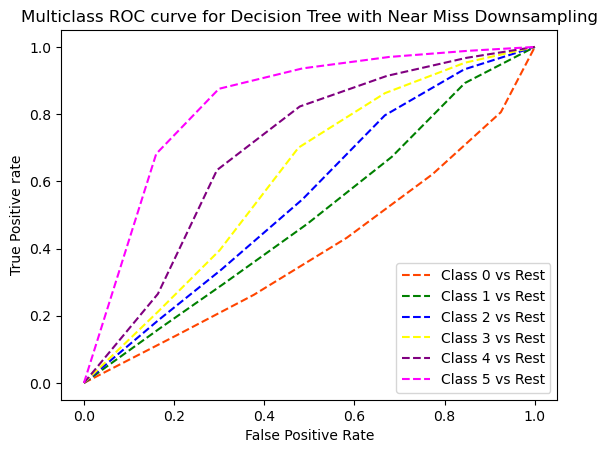

In [97]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_NM, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree with Near Miss Downsampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree with Near Miss Downsampling',dpi=300)

#### <font color='purple'>Decision Tree Algorithm with Near Miss Downsampling - Hyperparameter Tuning

In [99]:
params = {
          'max_depth': [3, 5, 10, 20],
          'min_samples_leaf': [10, 20, 50, 100],
          'max_features':['log2','sqrt',None]
}

In [100]:
grid_search_DT_NM = GridSearchCV(estimator=DT_classifier_NM,
                           param_grid=params,
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [101]:
%%time
grid_search_DT_NM.fit(X_train_dres_nm,y_train_dres_nm)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


python(3951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3959) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3960) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


CPU times: user 2.29 s, sys: 241 ms, total: 2.53 s
Wall time: 15.7 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 20],
                         'max_features': ['log2', 'sqrt', None],
                         'min_samples_leaf': [10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [102]:
score_df = pd.DataFrame(grid_search_DT_NM.cv_results_)
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
44,2.069878,0.014917,0.011556,0.002288,20,None,10,"{'max_depth': 20, 'max_features': None, 'min_s...",0.368101,0.411539,0.409627,0.385513,0.393695,0.017988,1
45,1.921230,0.059456,0.009526,0.001797,20,None,20,"{'max_depth': 20, 'max_features': None, 'min_s...",0.363195,0.412673,0.402245,0.380491,0.389651,0.019186,2
46,1.675295,0.004947,0.006356,0.000210,20,None,50,"{'max_depth': 20, 'max_features': None, 'min_s...",0.355627,0.397214,0.388799,0.365309,0.376737,0.016889,3
47,1.511229,0.010619,0.007840,0.000745,20,None,100,"{'max_depth': 20, 'max_features': None, 'min_s...",0.347527,0.383976,0.376232,0.348924,0.364165,0.016180,4
40,0.468814,0.010732,0.009803,0.001898,20,sqrt,10,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.337229,0.377311,0.365679,0.341171,0.355348,0.016721,5


#### <font color='purple'>Decision Tree Algorithm with SMOTE Upsampling

In [104]:
DT_classifier_SMOTE = tree.DecisionTreeClassifier(criterion='gini', max_depth=70)
DT_classifier_SMOTE.fit(X_train_ures_SMOTE,y_train_ures_SMOTE)
y_pred_SMOTE = DT_classifier_SMOTE.predict(X_test)

In [105]:
print('Performance of Decision Tree Algorithm with SMOTE Upsampling:\n')
print(confusion_matrix(y_test, y_pred_SMOTE))
print(classification_report(y_test, y_pred_SMOTE))
print('Accuracy:',accuracy_score(y_test, y_pred_SMOTE))
print('Precision:',precision_score(y_test, y_pred_SMOTE, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_SMOTE, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_SMOTE, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_SMOTE))

Performance of Decision Tree Algorithm with SMOTE Upsampling:

[[262433  23204   7410   3781   1744    673]
 [ 18400  50700   9966   2567   1100    333]
 [  4183  10143  29910   6543   1404    366]
 [  1772   2063   6556  19861   3724    517]
 [   629    622   1098   3834  10771   1466]
 [   204    151    208    375   1497   4660]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.89    299245
           1       0.58      0.61      0.60     83066
           2       0.54      0.57      0.56     52549
           3       0.54      0.58      0.56     34493
           4       0.53      0.58      0.56     18420
           5       0.58      0.66      0.62      7095

    accuracy                           0.76    494868
   macro avg       0.61      0.65      0.63    494868
weighted avg       0.77      0.76      0.77    494868

Accuracy: 0.7645170025138016
Precision: 0.7728817652460725
Recall: 0.7645170025138016
F1 Score: 0.7682769618531629
Cohen Ka

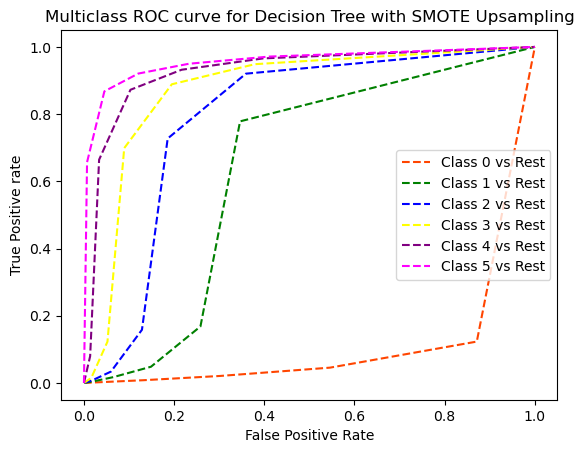

In [106]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_SMOTE, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree with SMOTE Upsampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree with SMOTE Upsampling',dpi=300)

#### <font color='purple'>Decision Tree Algorithm with Near Miss Downsampling and PCA

In [108]:
DT_classifier_NM_PCA = tree.DecisionTreeClassifier(criterion='gini')
DT_classifier_NM_PCA.fit(X_train_dres_nm_PCAreduced,y_train_dres_nm)
y_pred_NM_PCA = DT_classifier_NM_PCA.predict(X_test_NM_PCA_transformed)

In [109]:
print('Performance of Decision Tree Algorithm with Near Miss Downsampling and PCA:\n')
print(confusion_matrix(y_test, y_pred_NM_PCA))
print(confusion_matrix(y_test, y_pred_NM_PCA))
print(classification_report(y_test, y_pred_NM_PCA))
print('Accuracy:',accuracy_score(y_test, y_pred_NM_PCA))
print('Precision:',precision_score(y_test, y_pred_NM_PCA, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_NM_PCA, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_NM_PCA, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_NM_PCA))

Performance of Decision Tree Algorithm with Near Miss Downsampling and PCA:

[[44913 43758 49294 50456 48570 62254]
 [ 7960 15185 13959 13847 13432 18683]
 [ 3629  6309 11687  9629  8699 12596]
 [ 1954  2975  5192  9421  6282  8669]
 [  755  1128  1713  3300  6583  4941]
 [  167   223   350   520  1361  4474]]
[[44913 43758 49294 50456 48570 62254]
 [ 7960 15185 13959 13847 13432 18683]
 [ 3629  6309 11687  9629  8699 12596]
 [ 1954  2975  5192  9421  6282  8669]
 [  755  1128  1713  3300  6583  4941]
 [  167   223   350   520  1361  4474]]
              precision    recall  f1-score   support

           0       0.76      0.15      0.25    299245
           1       0.22      0.18      0.20     83066
           2       0.14      0.22      0.17     52549
           3       0.11      0.27      0.15     34493
           4       0.08      0.36      0.13     18420
           5       0.04      0.63      0.08      7095

    accuracy                           0.19    494868
   macro avg       

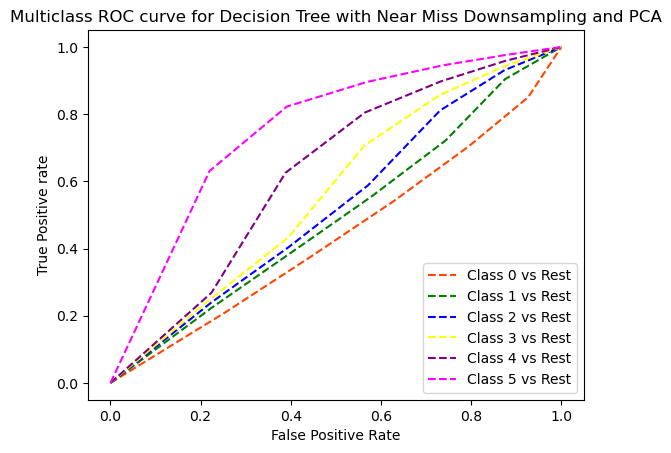

In [110]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_NM_PCA, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree with Near Miss Downsampling and PCA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree with Near Miss Downsampling and PCA',dpi=300)

#### <font color='purple'>Decision Tree Algorithm with SMOTE Upsampling and PCA

In [112]:
DT_classifier_SMOTE_PCA = tree.DecisionTreeClassifier(criterion='gini')
DT_classifier_SMOTE_PCA.fit(X_train_ures_SMOTE_PCAreduced,y_train_ures_SMOTE)
y_pred_SMOTE_PCA = DT_classifier_SMOTE_PCA.predict(X_test_SMOTE_PCA_transformed)

In [113]:
print('Performance of Decision Tree Algorithm with SMOTE Upsampling and PCA:\n')
print(confusion_matrix(y_test, y_pred_SMOTE_PCA))
print(confusion_matrix(y_test, y_pred_SMOTE_PCA))
print(classification_report(y_test, y_pred_SMOTE_PCA))
print('Accuracy:',accuracy_score(y_test, y_pred_SMOTE_PCA))
print('Precision:',precision_score(y_test, y_pred_SMOTE_PCA, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_SMOTE_PCA, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_SMOTE_PCA, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_SMOTE_PCA))

Performance of Decision Tree Algorithm with SMOTE Upsampling and PCA:

[[237031  29366  14838   9836   5703   2471]
 [ 18500  46446  10759   4238   2230    893]
 [  5861   9934  27184   6772   2074    724]
 [  2891   2741   6575  17765   3762    759]
 [  1227   1073   1461   3604   9623   1432]
 [   466    317    396    499   1384   4033]]
[[237031  29366  14838   9836   5703   2471]
 [ 18500  46446  10759   4238   2230    893]
 [  5861   9934  27184   6772   2074    724]
 [  2891   2741   6575  17765   3762    759]
 [  1227   1073   1461   3604   9623   1432]
 [   466    317    396    499   1384   4033]]
              precision    recall  f1-score   support

           0       0.89      0.79      0.84    299245
           1       0.52      0.56      0.54     83066
           2       0.44      0.52      0.48     52549
           3       0.42      0.52      0.46     34493
           4       0.39      0.52      0.45     18420
           5       0.39      0.57      0.46      7095

    acc

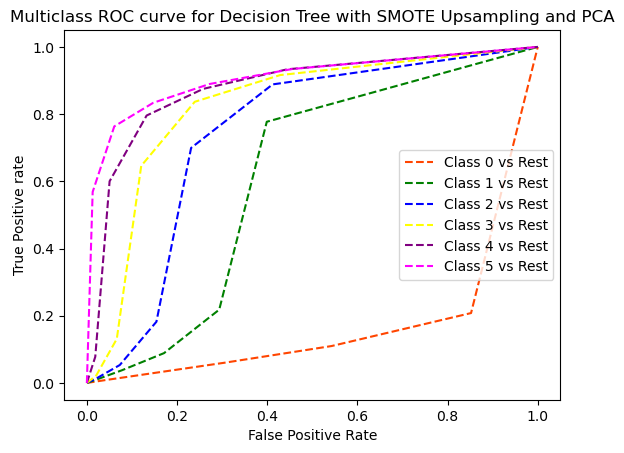

In [114]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_SMOTE_PCA, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree with SMOTE Upsampling and PCA')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree with SMOTE Upsampling and PCA',dpi=300)

#### <font color='purple'>Decision Tree Algorithm without resampling

In [116]:
DT_classifier = tree.DecisionTreeClassifier(criterion='gini')
DT_classifier.fit(X_train,y_train)
y_pred_DT = DT_classifier.predict(X_test)

In [117]:
print('Performance of Decision Tree Algorithm without resampling:\n')
print(confusion_matrix(y_test, y_pred_DT))
print(classification_report(y_test, y_pred_DT))
print('Accuracy:',accuracy_score(y_test, y_pred_DT))
print('Precision:',precision_score(y_test, y_pred_DT, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_DT, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_DT, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_DT))

Performance of Decision Tree Algorithm without resampling:

[[268285  20616   5839   2837   1261    407]
 [ 21903  48501   9270   2277    880    235]
 [  6108  10437  28453   5996   1252    303]
 [  2899   2423   6910  18386   3432    443]
 [  1194    885   1327   3867   9809   1338]
 [   426    247    295    459   1471   4197]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89    299245
           1       0.58      0.58      0.58     83066
           2       0.55      0.54      0.54     52549
           3       0.54      0.53      0.54     34493
           4       0.54      0.53      0.54     18420
           5       0.61      0.59      0.60      7095

    accuracy                           0.76    494868
   macro avg       0.62      0.61      0.62    494868
weighted avg       0.76      0.76      0.76    494868

Accuracy: 0.7630944009311574
Precision: 0.7620090560812774
Recall: 0.7630944009311574
F1 Score: 0.7625405289366866
Cohen Kappa

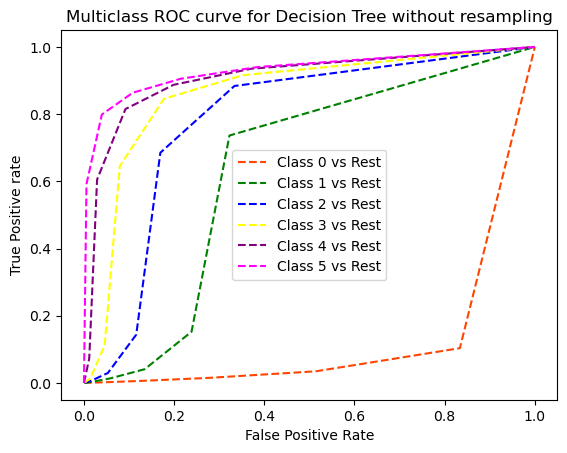

In [118]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_DT, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree without resampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree without resampling',dpi=300)

#### <font color='purple'>Decision Tree Algorithm without resampling  - Hyperparameter Tuning

In [120]:
DT_classifier.get_depth()

51

In [121]:
params = {
          'max_depth': [40, 50, 60, 70, 80],
          'max_features':['log2','sqrt',None]
}

In [122]:
grid_search = GridSearchCV(estimator=DT_classifier,
                           param_grid=params,
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [123]:
%%time
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


python(4419) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4421) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(4425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


CPU times: user 34.3 s, sys: 895 ms, total: 35.2 s
Wall time: 3min 30s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [40, 50, 60, 70, 80],
                         'max_features': ['log2', 'sqrt', None]},
             scoring='accuracy', verbose=1)

In [124]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
14,32.027859,0.164318,0.215974,0.014613,80,None,"{'max_depth': 80, 'max_features': None}",0.738666,0.738090,0.736986,0.738142,0.737971,0.000612,1
5,39.265083,0.120359,0.620449,0.147711,50,None,"{'max_depth': 50, 'max_features': None}",0.738553,0.738251,0.737234,0.737794,0.737958,0.000497,2
11,42.620638,0.093118,0.646325,0.179144,70,None,"{'max_depth': 70, 'max_features': None}",0.738068,0.737851,0.737754,0.737594,0.737817,0.000171,3
2,41.477238,0.168474,0.572760,0.075596,40,None,"{'max_depth': 40, 'max_features': None}",0.738421,0.737942,0.737649,0.737230,0.737811,0.000434,4
8,41.270967,0.138146,0.433295,0.043849,60,None,"{'max_depth': 60, 'max_features': None}",0.737977,0.737946,0.737576,0.737572,0.737768,0.000194,5


#### <font color='purple'>Decision Tree Algorithm without resampling - Setting the right hyperparameters

In [126]:
DT_classifier = tree.DecisionTreeClassifier(criterion='gini', max_depth=60)
DT_classifier.fit(X_train,y_train)
y_pred_DT = DT_classifier.predict(X_test)

In [127]:
print('Performance of Decision Tree Algorithm without resampling - After Hyperparameter Tuning:\n')
print(confusion_matrix(y_test, y_pred_DT))
print(classification_report(y_test, y_pred_DT))
print('Accuracy:',accuracy_score(y_test, y_pred_DT))
print('Precision:',precision_score(y_test, y_pred_DT, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_DT, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_DT, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_DT))

Performance of Decision Tree Algorithm without resampling - After Hyperparameter Tuning:

[[268157  20674   5923   2857   1201    433]
 [ 21930  48483   9290   2291    832    240]
 [  6207  10399  28467   5963   1221    292]
 [  2919   2398   6917  18420   3395    444]
 [  1182    862   1358   3884   9807   1327]
 [   415    223    316    458   1494   4189]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89    299245
           1       0.58      0.58      0.58     83066
           2       0.54      0.54      0.54     52549
           3       0.54      0.53      0.54     34493
           4       0.55      0.53      0.54     18420
           5       0.60      0.59      0.60      7095

    accuracy                           0.76    494868
   macro avg       0.62      0.61      0.62    494868
weighted avg       0.76      0.76      0.76    494868

Accuracy: 0.7628761609156381
Precision: 0.7618027804261648
Recall: 0.7628761609156381
F1 Score: 

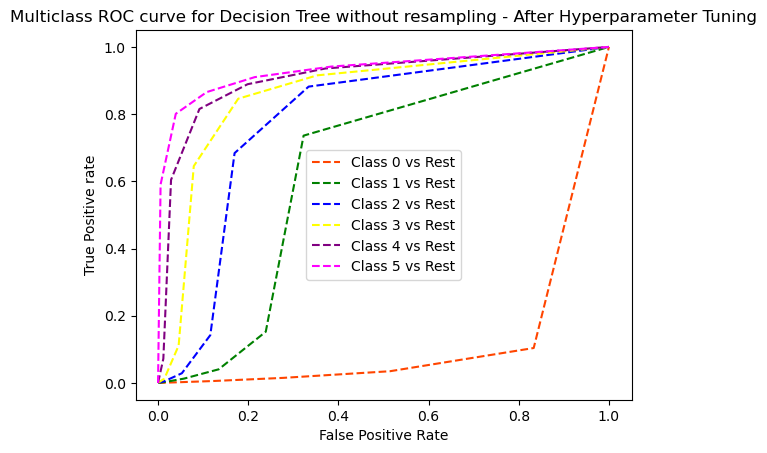

In [128]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_DT, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree without resampling - After Hyperparameter Tuning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree without resampling - After Hyperparameter Tuning',dpi=300)

#### <font color='darkblue'>KNN Algorithm without resampling

In [130]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

In [131]:
print('Performance of KNN Algorithm without resampling:\n')
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
print('Accuracy:',accuracy_score(y_test, y_pred_knn))
print('Precision:',precision_score(y_test, y_pred_knn, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_knn, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_knn, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_knn))

Performance of KNN Algorithm without resampling:

[[279686  14607   2814   1356    605    177]
 [ 28381  45507   7217   1372    464    125]
 [ 10156  10731  25771   4916    801    174]
 [  5048   2682   6777  17002   2731    253]
 [  2394    906   1447   3743   8833   1097]
 [   753    272    328    460   1412   3870]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89    299245
           1       0.61      0.55      0.58     83066
           2       0.58      0.49      0.53     52549
           3       0.59      0.49      0.54     34493
           4       0.59      0.48      0.53     18420
           5       0.68      0.55      0.61      7095

    accuracy                           0.77    494868
   macro avg       0.65      0.58      0.61    494868
weighted avg       0.76      0.77      0.76    494868

Accuracy: 0.7692334117380797
Precision: 0.7550380350070923
Recall: 0.7692334117380797
F1 Score: 0.7597991642138022
Cohen Kappa Score: 0.

In [ ]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_knn, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for KNN without resampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for KNN without resampling',dpi=300)

#### <font color='darkblue'>KNN Algorithm without resampling  - Hyperparameter Tuning

In [ ]:
k_range = list(range(1, 10))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knn_classifier, param_grid, cv=3, scoring='accuracy', return_train_score=False,verbose=1)
grid_search=grid.fit(X_train, y_train)

In [ ]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(5,"mean_test_score")

#### <font color='darkblue'>KNN Algorithm without resampling - Setting the right hyperparameters

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

In [ ]:
print('Performance of KNN Algorithm without resampling - After Hyperparameter Tuning:\n')
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
print('Accuracy:',accuracy_score(y_test, y_pred_knn))
print('Precision:',precision_score(y_test, y_pred_knn, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_knn, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_knn, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_knn))

In [ ]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_knn, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for KNN without resampling - After Hyperparameter Tuning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for KNN without resampling - After Hyperparameter Tuning',dpi=300)

#### <font color='darkblue'>KNN Algorithm with SMOTE Upsampling

In [ ]:
knn_classifier_SMOTE = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn_classifier_SMOTE.fit(X_train_ures_SMOTE, y_train_ures_SMOTE)
y_pred_knn_SMOTE = knn_classifier_SMOTE.predict(X_test)

In [ ]:
print('Performance of KNN Algorithm with SMOTE Upsampling:\n')
print(confusion_matrix(y_test, y_pred_knn_SMOTE))
print(classification_report(y_test, y_pred_knn_SMOTE))
print('Accuracy:',accuracy_score(y_test, y_pred_knn_SMOTE))
print('Precision:',precision_score(y_test, y_pred_knn_SMOTE, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_knn_SMOTE, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_knn_SMOTE, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_knn_SMOTE))

In [ ]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_knn_SMOTE, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for KNN with SMOTE Upsampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for KNN with SMOTE Upsampling',dpi=300)

#### <font color='darkblue'>KNN Algorithm with Near Miss Downsampling

In [ ]:
knn_classifier_NM = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn_classifier_NM.fit(X_train_dres_nm, y_train_dres_nm)
y_pred_knn_NM = knn_classifier_NM.predict(X_test)

In [ ]:
print('Performance of KNN Algorithm with NM Downsampling:\n')
print(confusion_matrix(y_test, y_pred_knn_NM))
print(classification_report(y_test, y_pred_knn_NM))
print('Accuracy:',accuracy_score(y_test, y_pred_knn_NM))
print('Precision:',precision_score(y_test, y_pred_knn_NM, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_knn_NM, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_knn_NM, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_knn_NM))

In [ ]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_knn_NM, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for KNN with Near Miss Downsampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for KNN with Near Miss Downsampling',dpi=300)

#### <font color='violet'>Naive Bayes Algorithm without resampling

In [ ]:
NB_classifier = GaussianNB()
NB_classifier.fit(X_train, y_train)
y_pred_NB = NB_classifier.predict(X_test)

In [ ]:
print('Performance of Naive Bayes Algorithm without resampling:\n')
print(confusion_matrix(y_test, y_pred_NB))
print(classification_report(y_test, y_pred_NB))
print('Accuracy:',accuracy_score(y_test, y_pred_NB))
print('Precision:',precision_score(y_test, y_pred_NB, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_NB, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_NB, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_NB))

In [ ]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_NB, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Naive Bayes without resampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Naive Bayes without resampling',dpi=300)

#### <font color='darkgreen'>Random Forest Algorithm without resampling

In [ ]:
RF_classifier = RandomForestClassifier(n_estimators = 20, max_depth=70, random_state=0)
RF_classifier.fit(X_train, y_train)
y_pred_RF = RF_classifier.predict(X_test)

In [ ]:
print('Performance of RF Algorithm without resampling:\n')
print(confusion_matrix(y_test, y_pred_RF))
print(classification_report(y_test, y_pred_RF))
print('Accuracy:',accuracy_score(y_test, y_pred_RF))
print('Precision:',precision_score(y_test, y_pred_RF, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_RF, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_RF, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_RF))

In [ ]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_RF, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Random Forest without resampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Random Forest without resampling',dpi=300)

#### <font color='darkgreen'>Random Forest Algorithm without resampling - Hyperparameter Tuning

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [ ]:
RF_random = RandomizedSearchCV(estimator = RF_classifier, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=0, n_jobs = -1)
RF_random.fit(X_train, y_train)

In [ ]:
RF_random.best_params_

#### <font color='darkgreen'>Random Forest Algorithm without resampling - Setting the right Hyperparameters

In [ ]:
RF_classifier = RandomForestClassifier(n_estimators = 50, max_depth=80, bootstrap=False, max_features='sqrt', random_state=0)
RF_classifier.fit(X_train, y_train)
y_pred_RF = RF_classifier.predict(X_test)

In [ ]:
print('Performance of RF Algorithm without resampling - After Hyperparamter Tuning:\n')
print(confusion_matrix(y_test, y_pred_RF))
print(classification_report(y_test, y_pred_RF))
print('Accuracy:',accuracy_score(y_test, y_pred_RF))
print('Precision:',precision_score(y_test, y_pred_RF, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_RF, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_RF, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_RF))

In [ ]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_RF, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Random Forest without resampling - After Hyperparameter Tuning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Random Forest without resampling - After Hyperparameter Tuning',dpi=300)

### <font color='orangered'> Performance Analysis

In [ ]:
all_labels = pd.DataFrame()
all_labels['Actual_label'] = y_test
all_labels['y_pred_DT'] = y_pred_DT
all_labels['y_pred_NM'] = y_pred_NM
all_labels['y_pred_SMOTE'] = y_pred_SMOTE
all_labels['y_pred_NM_PCA'] = y_pred_NM_PCA
all_labels['y_pred_SMOTE_PCA'] = y_pred_SMOTE_PCA
all_labels['y_pred_KNN'] = y_pred_knn
all_labels['y_pred_KNN_SMOTE'] = y_pred_knn_SMOTE
all_labels['y_pred_KNN_NM'] = y_pred_knn_NM
all_labels['y_pred_NB'] = y_pred_NB
all_labels['y_pred_RF'] = y_pred_RF

In [138]:
data = [
{'Algorithm':'Decision Tree without resampling' ,'Accuracy':0.7628741401747536,'Precision':0.7618010547062107,'Recall':0.7628741401747536,'F1 Score':0.7623262860089722,'Cohen Kappa Score':0.5958579722704211},
{'Algorithm':'Decision Tree with Near Miss Downsampling','Accuracy':0.2256035953021816,'Precision':0.5447079836581246,'Recall':0.2256035953021816,'F1 Score':0.26347777488012986,'Cohen Kappa Score':0.0795499766101283},
{'Algorithm':'Decision Tree with SMOTE Upsampling','Accuracy':0.7640724395192253,'Precision':0.7725016378855349,'Recall':0.7640724395192253,'F1 Score':0.7678593615099155,'Cohen Kappa Score':0.6070235893225333},
{'Algorithm':'Decision Tree with Near Miss Downsampling and PCA','Accuracy':0.18699936144588053,'Precision':0.5181792792486399,'Recall':0.18699936144588053,'F1 Score':0.22126727969947696,'Cohen Kappa Score':0.05821959636936613},
{'Algorithm':'Decision Tree with SMOTE Upsampling and PCA','Accuracy':0.6911540047042848,'Precision':0.7219976266154619,'Recall':0.6911540047042848,'F1 Score':0.7033576010387472,'Cohen Kappa Score':0.5046310712860997},
{'Algorithm':'KNN without resampling','Accuracy':0.7986513575337262,'Precision':0.7982935187700809,'Recall':0.7986513575337262,'F1 Score':0.7984710410835046,'Cohen Kappa Score':0.6574980649397748},
{'Algorithm':'KNN with SMOTE Upsampling','Accuracy':0.7952666165522927,'Precision':0.801758151083889,'Recall':0.7952666165522927,'F1 Score':0.7981975830544615,'Cohen Kappa Score':0.6578269982214404},
{'Algorithm':'KNN with Near Miss Upsampling','Accuracy':0.2325084669043058,'Precision':0.5664887557511156,'Recall':0.2325084669043058,'F1 Score':0.26887856642437447,'Cohen Kappa Score':0.09355157402001324},
{'Algorithm':'Naive Bayes without resampling','Accuracy':0.5851439171657896,'Precision':0.4499104487639562,'Recall':0.5851439171657896,'F1 Score':0.4804411924156227,'Cohen Kappa Score':0.08074571293428756},
{'Algorithm':'Random Forest without resampling','Accuracy':0.8091046501289233,'Precision':0.797058313313492,'Recall':0.8091046501289233,'F1 Score':0.7988662259155133,'Cohen Kappa Score':0.6553298267952152}]
performance_metrics = pd.DataFrame(data)
performance_metrics.sort_values(by=['Accuracy', 'Cohen Kappa Score'], ascending=False)

,Algorithm,Accuracy,Precision,Recall,F1 Score,Cohen Kappa Score
9,Random Forest without resampling,0.809105,0.797058,0.809105,0.798866,0.655330
5,KNN without resampling,0.798651,0.798294,0.798651,0.798471,0.657498
6,KNN with SMOTE Upsampling,0.795267,0.801758,0.795267,0.798198,0.657827
2,Decision Tree with SMOTE Upsampling,0.764072,0.772502,0.764072,0.767859,0.607024
0,Decision Tree without resampling,0.762874,0.761801,0.762874,0.762326,0.595858
4,Decision Tree with SMOTE Upsampling and PCA,0.691154,0.721998,0.691154,0.703358,0.504631
8,Naive Bayes without resampling,0.585144,0.449910,0.585144,0.480441,0.080746
7,KNN with Near Miss Upsampling,0.232508,0.566489,0.232508,0.268879,0.093552
1,Decision Tree with Near Miss Downsampling,0.225604,0.544708,0.225604,0.263478,0.079550
3,Decision Tree with Near Miss Downsampling and PCA,0.186999,0.518179,0.186999,0.221267,0.058220
